In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam

import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output

import sys
sys.path.insert(0,'..')

import sampler
import camera
import optimization
from sdf import DeepSDF, SphereSDF, PositionalSDF



In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cam = camera.PerspectiveCamera()
sdf = SphereSDF(torch.zeros((3), device=device), 1)

# create samples
uv = sampler.grid_2d(64, 64).to(device).unsqueeze(0)
depth = torch.zeros((*uv.shape[:-1], 1), device=uv.device).requires_grad_(True)
pose = torch.zeros((4,4), device=uv.device)
pose[:3, :3] = torch.eye(3)
pose[2,3] = -3

foo = lambda d: sdf(cam(uv, d, pose))

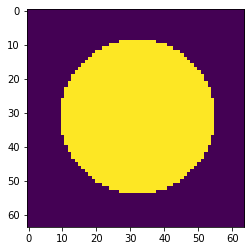

In [3]:
import matplotlib.pyplot as plt

for i in range(10):
    
    clear_output(wait=True)
    plt.imshow(foo(depth).detach().cpu().numpy().reshape(64,64,1) < 1e-6)
    #plt.imshow(depth.detach().numpy().reshape(64,64,1))
    plt.show()
    
    depth = optimization.lm(depth, foo, 1e-4)
    
mask_gt = torch.sigmoid(- foo(depth) / 1e-3).view(64,64,1).detach()

In [68]:

# modified implementation
class PositionalSDF(nn.Module):
    def __init__(self, num_layers):
        super(PositionalSDF, self).__init__()
        self.num_layers = num_layers
        
        # positional encoding
        self.pe = nn.Linear(3+256, 128, bias=True)
        nn.init.normal_(self.pe.weight, 0.0, 1e+1)

        for i in range(num_layers):
            in_dim = 512
            out_dim = 512

            if i == 0:
                in_dim = 256
            if i == num_layers-1:
                out_dim = 1
            elif i == int(num_layers/2)-1:
                out_dim = 512 - (256) #259

            # weight-normalized linear FC
            setattr(self, "fc" + str(i), nn.utils.weight_norm(nn.Linear(in_dim, out_dim)))

            # weight normalization??
            setattr(self, "bn" + str(i), nn.LayerNorm(out_dim))

        self.dropout = nn.Dropout(0.1)

        for p in self.parameters():
            if len(p.shape) == 1:
                nn.init.uniform(p, 0., 0.)

        

    def forward(self, x):
        num_layers = self.num_layers
        
        pi = np.pi
        x = self.pe(x)
        x = torch.cat([torch.sin(2*pi*x), torch.cos(2*pi*x)], dim=-1)
        
        x_origin = x

        for i in range(num_layers):
            fc = getattr(self, "fc" + str(i))
            bn = getattr(self, "bn" + str(i))

            if i == int(num_layers/2):
                x = torch.cat([x, x_origin], dim=-1)

            x = fc(x)

            if i < self.num_layers:
                x = F.leaky_relu(x) #torch.tanh(x)
                x = self.dropout(x)

            
        output = F.leaky_relu(x) #torch.tanh(x)
        return output

In [83]:


# modified implementation
class DeepSDF(nn.Module):
    def __init__(self, num_layers):
        super(DeepSDF, self).__init__()
        self.num_layers = num_layers

        for i in range(num_layers):
            in_dim = 512
            out_dim = 512

            if i == 0:
                in_dim = 3+256  #259
            elif i == num_layers-1:
                out_dim = 1
            elif i == int(num_layers/2)-1:
                out_dim = 512 - (3+256) #259

            # weight-normalized linear FC
            setattr(self, "fc" + str(i), nn.utils.weight_norm(nn.Linear(in_dim, out_dim)))

            # weight normalization??
            setattr(self, "bn" + str(i), nn.LayerNorm(out_dim))

        self.dropout = nn.Dropout(0.1)

        for p in self.parameters():
            if len(p.shape) == 1:
                nn.init.uniform(p, 0., 0.)

    def forward(self, x):
        num_layers = self.num_layers
        x_origin = x

        for i in range(num_layers):
            fc = getattr(self, "fc" + str(i))
            bn = getattr(self, "bn" + str(i))

            if i == int(num_layers/2):
                x = torch.cat([x, x_origin], dim=-1)

            x = fc(x)

            if i < self.num_layers:
                x = F.leaky_relu(x) #torch.tanh(x)
                x = self.dropout(x)

            
        output = torch.tanh(x)
        return output

In [84]:
cam = camera.PerspectiveCamera()

sdf = PositionalSDF(8).to(device)
sdf.eval()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.


PositionalSDF(
  (pe): Linear(in_features=259, out_features=128, bias=True)
  (fc0): Linear(in_features=256, out_features=512, bias=True)
  (bn0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (bn1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (bn2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (bn3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc4): Linear(in_features=512, out_features=512, bias=True)
  (bn4): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc5): Linear(in_features=512, out_features=512, bias=True)
  (bn5): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc6): Linear(in_features=512, out_features=512, bias=True)
  (bn6): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc7): Linear(in_features=512, out_features=1, 

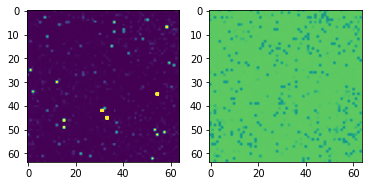

In [ ]:
adam = Adam(sdf.parameters(), lr=1e-4)
li = []
for j in range(500):
    # create samples
    uv = sampler.grid_2d(64, 64).to(device).unsqueeze(0)
    depth = (torch.randn((*uv.shape[:-1], 1), device=uv.device) * 1e-2 + 1e-2).requires_grad_(True)
    pose = torch.zeros((4,4), device=uv.device)
    pose[:3, :3] = torch.eye(3)
    pose[2,3] = -3
    
    foo = lambda d: sdf(torch.cat([cam(uv, d, pose), torch.zeros(*uv.shape[:-1], 256, device=uv.device)], dim=-1))
    
    for i in range(5):
        depth = optimization.lm(depth, foo, 1e-4)
        
    mask = torch.sigmoid(- foo(depth) / 1e-3).view(64,64,1)
    
    adam.zero_grad()
    loss = ((mask - mask_gt) ** 2).mean()    # l2 loss
    #loss_f = nn.BCELoss()
    #loss = loss_f(mask, mask_gt)              # bce loss
    
    li.append(loss.item())
    loss.backward()
    adam.step()
    

    clear_output(wait=True)
    
    plt.subplot(1, 2, 1)
    plt.imshow((depth).view(64,64,1).detach().cpu().numpy())
    plt.clim(0,3)
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask.detach().cpu().numpy())
    plt.clim(-1,1)
    plt.show()


In [ ]:
plt.plot(range(500), li)